In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal as mvn

# MAP Classifier

In [2]:
features = 3 # number of features
samples = 10000 #number of samples to be generated
L=3 #number of class labels 1 2 3

# Mean matrix for different distributions
mean = np.zeros((features,4)) 
#mean matrix for guassian 1 for class 1
mean[:,0]= [-1,2,-1]
#mean matrix for guassian 2 for class 2
mean[:,1]= [2,-1,-1]
#mean matrix for mixture guassian of 2 and 3 for class 3
mean[:,2]= [-1,-1,2]
mean[:,3]= [1,2,2]

# Covariance matrix for 4 different distributions
cov = np.zeros((features,features,4))
s=0.2e1; I=np.eye(features)

cov[:,:,0]= s ** 2 * I
cov[:,:,1]= s ** 2 * I
cov[:,:,2]= s ** 2 * I

A=np.random.rand(features,features);a=0.1
cov[:,:,3] = (s**2) *(I + a*A)*(I + a*A) 

In [3]:
def generate_labels(priors,samples):
    labels =np.random.choice(np.arange(1,len(priors) +1), samples, p=priors)
    return labels

# priors for 3 classes
priors = [0.3,0.3 ,0.4]  
labels=generate_labels(priors,samples)
N_labels=[]
for i in range(len(priors)):
    N_labels.append(sum(labels==i+1))

In [4]:
def generate_data(mean,cov, samples,features):
    X = np.zeros((features,samples))
    
    # Generate the data
    for index in range(samples):
        if(labels[index] == 1): #one guassian for class 1
            X[:,index] = np.random.multivariate_normal(mean[:,0],cov[:,:,0],1)

        elif(labels[index] == 2): #one guassian for class 2
            X[:,index] = np.random.multivariate_normal(mean[:,1],cov[:,:,1],1)

        else: #one mixture guassian for class 3 with equal weights

            X[:,index] = (0.5* np.random.multivariate_normal(mean[:,2],cov[:,:,2],1)
                        + 0.5* np.random.multivariate_normal(mean[:,3],cov[:,:,3],1))
        
    return X

X= generate_data(mean,cov, samples,features)

C:\Users\vanshika\AppData\Local\Temp/ipykernel_9480/2860813106.py:15: RuntimeWarning: covariance is not positive-semidefinite.
  + 0.5* np.random.multivariate_normal(mean[:,3],cov[:,:,3],1))


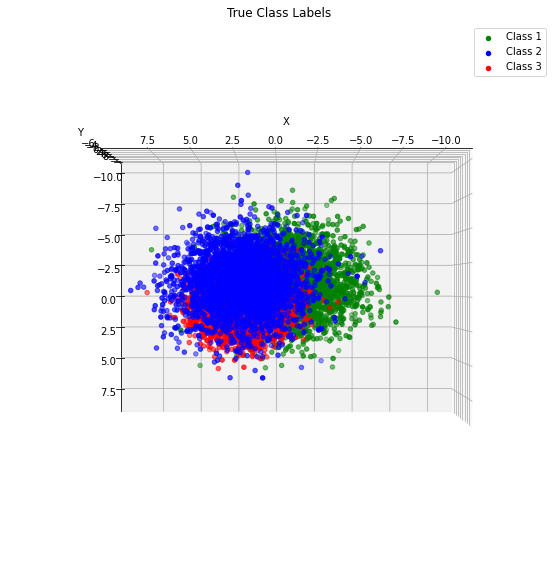

In [5]:
# plot the actual distributions
x1= [i for i in range(samples) if(labels[i] == 1)]
x2= [i for i in range(samples) if(labels[i] == 2)]
x3= [i for i in range(samples) if(labels[i] == 3)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[0,x1],X[1,x1],X[2,x1],'o',c='green',label='Class 1')
ax.scatter(X[0,x2],X[1,x2],X[2,x2],'+',c='blue',label='Class 2')
ax.scatter(X[0,x3],X[1,x3],X[2,x3],'x',c='red',label='Class 3')

ax.view_init(elev=180, azim=90)
plt.legend()
plt.title('True Class Labels')
plt.xlabel('X')
plt.ylabel ('Y')

plt.show()

In [6]:
#functions to compute risk
def compute_mean_cov(X,labels):
    features=X.shape[0]
    L=len(np.unique(labels))
    X_mean=np.zeros((features,L))
    X_cov=np.zeros((features,features,L))

    for l in range(L):
        X_mean[:,l]=(X[:,labels==l+1]).mean(axis=1)
        X_cov[:,:,l]=np.cov(X[:,labels==l+1])
        
    return X_cov, X_mean

def evalGuassPDF(X,mu,sigma):
    n=X.shape[0]
    N=X.shape[1]
    C= (2*np.pi) ** (-n/2) *np.linalg.det(sigma) ** (-1/2)
    a=X-mu[:,np.newaxis]
    b=np.dot(np.linalg.inv(sigma),a)
    px= C* np.exp(-0.5 * np.sum(a*b,axis=0))
    return px

def estimate_risk(X,labels,priors,loss_matrix):
    X_cov,X_mean= compute_mean_cov(X,labels)
    
    samples=X.shape[1]
    L=len(np.unique(labels))
    px_l=np.zeros((samples,L))
    
    for l in range(L):
        px_l[:,l] = (evalGuassPDF(X,X_mean[:,l],X_cov[:,:,l]))
        
    px= np.dot(np.array(priors).reshape(1,L), px_l.T)
    class_posteriors= px_l * np.array([priors] *samples) /(np.vstack((px,px,px)).T)
    Risks= np.dot((loss_matrix) ,class_posteriors.T)
    
    return Risks, class_posteriors

## Loss Matrix 0-1

In [7]:
#loss matrix for 0-1 loss
loss_matrix =np.ones(features)- np.eye(features)
Risks, class_posteriors= estimate_risk(X,labels,priors,loss_matrix)
decision=np.argmin(Risks, axis=0)

In [35]:
loss_matrix

array([[0., 1., 1.],
       [1., 0., 1.],
       [1., 1., 0.]])

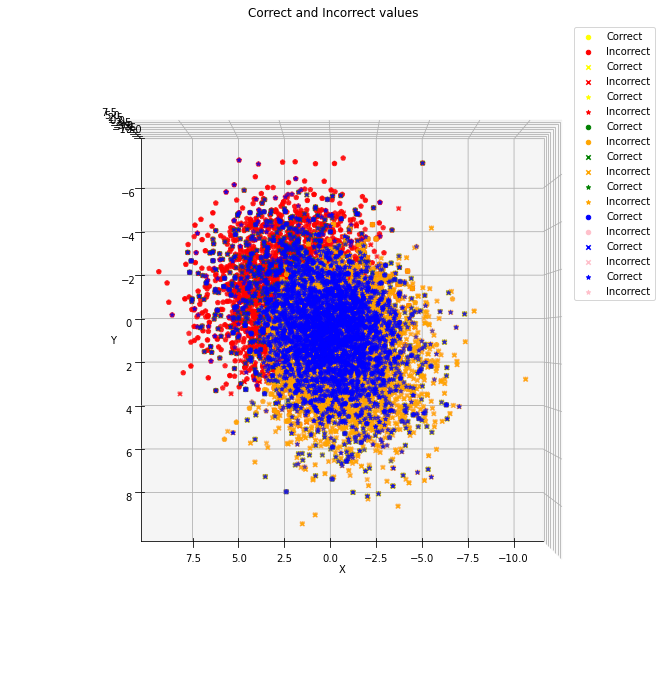

array([[2174.,  292.,  257.],
       [ 329., 2258.,  224.],
       [ 531.,  410., 3525.]])

In [17]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')

def estimate_confusion_matrix(decision,labels,X):
    L=X.shape[0]
    D=len(np.unique(decision))
    ConfusionMatrix=np.zeros((D,L))
    colors1=['yellow','green','blue']    #correct values
    colors2=['red','orange','pink']  #incorrect values
    m=['o','x','*']  
    
    for d in range(D):
        for l in range(1,L+1):
            idx=((decision==d) & (labels == l)) 
            ConfusionMatrix[d][l-1]= sum(idx) # / sum((labels == l))
            
            ICidx=((decision!=d) & (labels != l))
            #print(sum(idx))
            
            x=X[0,0:sum(idx)]
            y=X[1,0:sum(idx)]
            z=X[2,0:sum(idx)]

            ax.scatter(x,y,z,c=colors1[d],marker=m[l-1],label='Correct')

            x1=X[0,(ICidx)]
            y1=X[1,(ICidx)]
            z1=X[2,(ICidx)]

            ax.scatter(x1,y1,z1,c=colors2[d],marker=m[l-1],label='Incorrect')  
            ax.view_init(elev=90, azim=90)

    plt.legend()
    plt.title('Correct and Incorrect values')
    plt.xlabel('X')
    plt.ylabel ('Y')       
    plt.show()
        
    return ConfusionMatrix

ConfusionMatrix= estimate_confusion_matrix(decision,labels,X)
ConfusionMatrix

In [22]:
pe= ConfusionMatrix[0][1] + ConfusionMatrix[0][2] +ConfusionMatrix[1][0] + ConfusionMatrix[1][2] +ConfusionMatrix[2][1] + ConfusionMatrix[2][0] 
pe/samples * 100

20.43

In [11]:
FP = ConfusionMatrix.sum(axis=0) - np.diag(ConfusionMatrix)   #column wise
FN = ConfusionMatrix.sum(axis=1) - np.diag(ConfusionMatrix)   #row wise
TP = np.diag(ConfusionMatrix)
TN = sum(ConfusionMatrix) - (FP + FN + TP)
accuracy= (TN+ TP)/ (FP+FN+TP+TN)
accuracy*100

array([53.75042045, 57.94487921, 65.23972603])

In [39]:
ConfusionMatrix

array([[2174.,  292.,  257.],
       [ 329., 2258.,  224.],
       [ 531.,  410., 3525.]])

In [38]:
loss_matrix_10=np.array([[0,1,10],
                        [1,0,10],
                        [1,1,0]])
loss_matrix_100=np.array([[0,1,100],
                          [1,0,100],
                          [1,1,0]])
loss_matrix_100 #loss_matrix_100

array([[  0,   1, 100],
       [  1,   0, 100],
       [  1,   1,   0]])

## Loss matrix for 0-1 with 10 times care for L=3

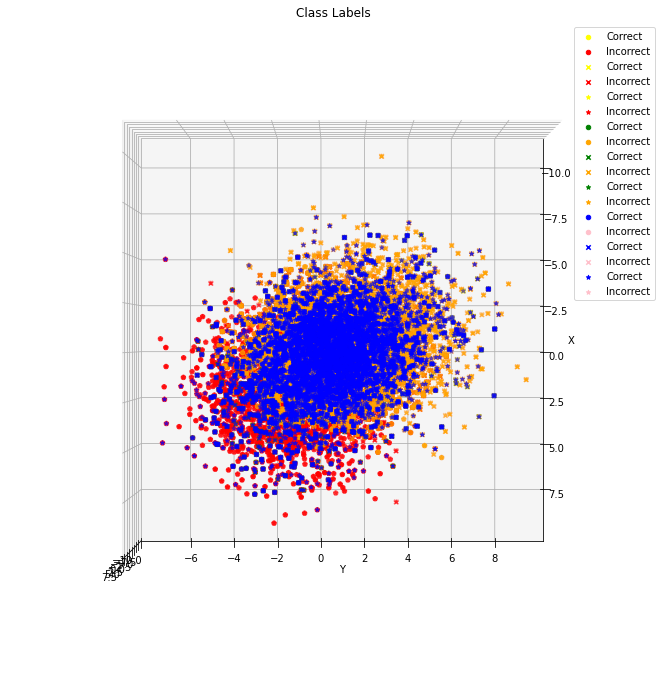

array([[1564.,  167.,   25.],
       [ 206., 1706.,   29.],
       [1264., 1087., 3952.]])

In [25]:
expectedRisks10, classpost10= estimate_risk(X,labels,priors,loss_matrix_10)
decision10=np.argmin(expectedRisks10, axis=0)

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')

def estimate_confusion_matrix(decision,labels,X):
    L=X.shape[0]
    D=len(np.unique(decision))
    ConfusionMatrix=np.zeros((D,L))
    colors1=['yellow','green','blue']
    colors2=['red','orange','pink']  #incorrect values
    m=['o','x','*']  

    for d in range(D):
        for l in range(1,L+1):
            idx=((decision==d) & (labels == l)) 
            ConfusionMatrix[d][l-1]= sum(idx) # / sum((labels == l)) 
            ICidx=((decision!=d) & (labels != l))

            # true values-- correct values
            x=X[0,0:sum(idx)]
            y=X[1,0:sum(idx)]
            z=X[2,0:sum(idx)]

            # incorrect values
            x1=X[0,(ICidx)]
            y1=X[1,(ICidx)]
            z1=X[2,(ICidx)]
                
            ax.scatter(x,y,z,c=colors1[d],marker=m[l-1],label='Correct')
            ax.scatter(x1,y1,z1,c=colors2[d],marker=m[l-1],label='Incorrect')  
            ax.view_init(elev=90, azim=0)

    plt.legend()
    plt.title('Class Labels')
    plt.xlabel('X')
    plt.ylabel ('Y')       
    plt.show()
        
    return ConfusionMatrix

ConfusionMatrix10= estimate_confusion_matrix(decision10,labels,X)
ConfusionMatrix10

In [26]:
FP10 = ConfusionMatrix10.sum(axis=0) - np.diag(ConfusionMatrix10)   #column wise
FN10 = ConfusionMatrix10.sum(axis=1) - np.diag(ConfusionMatrix10)   #row wise
TP10 = np.diag(ConfusionMatrix10)
TN10 = sum(ConfusionMatrix10) - (FP10 + FN10 + TP10)
accuracy10= (TN10 + TP10)/ (FP10 +FN10 +TP10 +TN10)
accuracy10*100

array([45.22083059, 49.69594595, 39.96505242])

In [27]:
pe10= ConfusionMatrix10[0][1] + ConfusionMatrix10[0][2] +ConfusionMatrix10[1][0] + ConfusionMatrix10[1][2] +ConfusionMatrix10[2][1] + ConfusionMatrix10[2][0] 
pe10/samples * 100

27.779999999999998

## Loss matrix for 0-1 with 100 times care for L=3

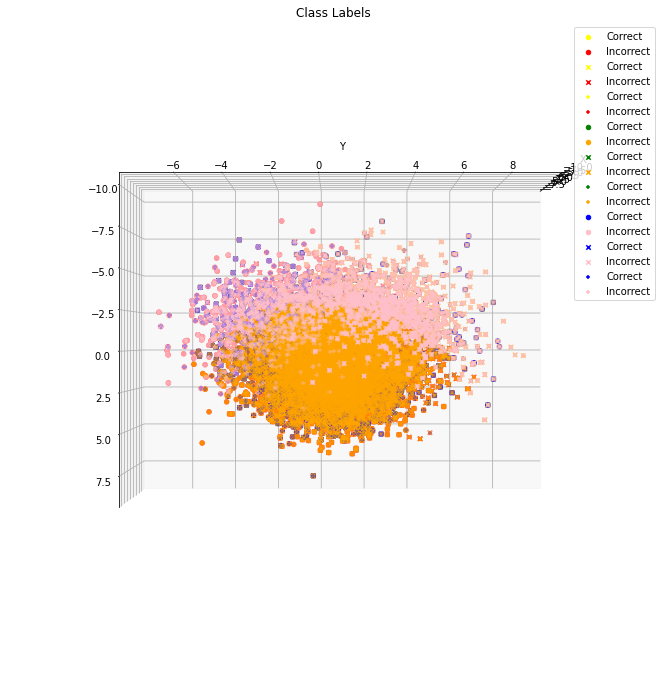

In [28]:
expectedRisks100, classpost100= estimate_risk(X,labels,priors,loss_matrix_100)
decision100=np.argmin(expectedRisks100, axis=0)

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')

def estimate_confusion_matrix(decision,labels,X):
    L=X.shape[0]
    D=len(np.unique(decision))
    ConfusionMatrix=np.zeros((D,L))
    colors1=['yellow','green','blue']
    colors2=['red','orange','pink']
    m=['o','x','+']  

    for d in range(D):
        for l in range(1,L+1):
            idx=((decision==d) & (labels == l)) 
            ConfusionMatrix[d][l-1]= sum(idx) # / sum((labels == l)) 
            ICidx=((decision!=d) & (labels != l))

#           # true values-- correct values
            x=X[0,0:sum(idx)]
            y=X[1,0:sum(idx)]
            z=X[2,0:sum(idx)]

#          # incorrect values
            x1=X[0,(ICidx)]
            y1=X[1,(ICidx)]
            z1=X[2,(ICidx)]
                
            ax.scatter(x,y,z,c=colors1[d],marker=m[l-1],label='Correct')
            ax.scatter(x1,y1,z1,c=colors2[d],marker=m[l-1],label='Incorrect')  
            ax.view_init(elev=360, azim=180)

    plt.legend()
    plt.title('Class Labels')
    plt.xlabel('X')
    plt.ylabel ('Y')       
    plt.show()
        
    return ConfusionMatrix

ConfusionMatrix100= estimate_confusion_matrix(decision100,labels,X)

In [29]:
FP100 = ConfusionMatrix100.sum(axis=0) - np.diag(ConfusionMatrix100)   #column wise
FN100 = ConfusionMatrix100.sum(axis=1) - np.diag(ConfusionMatrix100)   #row wise
TP100 = np.diag(ConfusionMatrix100)
TN100 = sum(ConfusionMatrix100) - (FP100 + FN100 + TP100)
accuracy100= (TN100 + TP100)/ (FP100 +FN100 +TP100 +TN100)
accuracy100*100

array([27.75214239, 33.24324324,  4.59311033])

In [30]:
pe100= ConfusionMatrix100[0][1] + ConfusionMatrix100[0][2] +ConfusionMatrix100[1][0] + ConfusionMatrix100[1][2] +ConfusionMatrix100[2][1] + ConfusionMatrix100[2][0] 
pe100/samples * 100

39.95

In [19]:
#comparison with confusion matrix of 0-1 loss 
ConfusionMatrix, ConfusionMatrix100

(array([[2165.,  308.,  259.],
        [ 287., 2215.,  225.],
        [ 521.,  416., 3604.]]),
 array([[8.780e+02, 7.400e+01, 1.000e+00],
        [8.100e+01, 1.056e+03, 3.000e+00],
        [2.014e+03, 1.809e+03, 4.084e+03]]))

In [20]:
sum(decision100==2) # predictions for L=3 

7907

In [31]:
sum=0
for j in range(3):
    for i in range(3):
        sum+=(loss_matrix[i][j] * ConfusionMatrix[i][j])
erisk=sum/samples

In [32]:
sum10=0
for j in range(3):
    for i in range(3):
        sum10 +=(loss_matrix_10[i][j] * ConfusionMatrix10[i][j])
erisk10= sum10/samples

In [33]:
sum100=0
for j in range(3):
    for i in range(3):
        sum100 +=(loss_matrix_100[i][j] * ConfusionMatrix100[i][j])
erisk100= sum100/samples

In [34]:
erisk, erisk10, erisk100

(0.2043, 0.3264, 0.4787)